# Klasifikasi Malaria pada Citra Sel Darah Menggunakan Vision Transformer

## Mount Google Drive & Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = "/content/drive/MyDrive/TA/Malaria Cell Dataset"

## Exploratory Data Analysis (EDA)

### Menampilkan Contoh Gambar dari Setiap Kelas

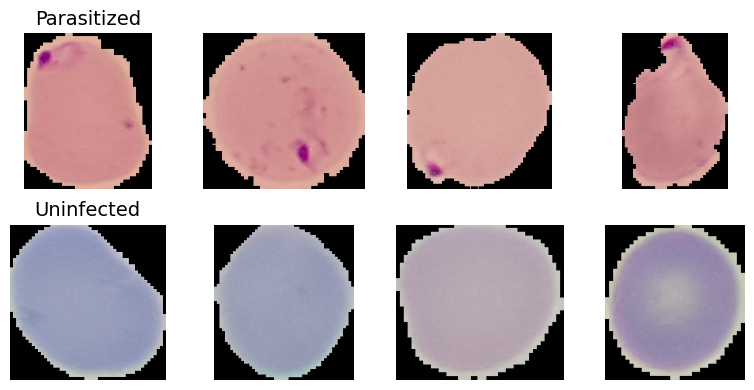

In [ ]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Fungsi untuk menampilkan contoh gambar dari dataset
def show_sample_images(dataset_path, num_samples=4):
    classes = os.listdir(dataset_path)

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 2, len(classes) * 2))

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        images = random.sample(os.listdir(class_path), num_samples)

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(cls, fontsize=14)

    plt.tight_layout()
    plt.show()

show_sample_images(f"{data_dir}/train")

### Melihat Distribusi Jumlah Gambar per Kelas

In [3]:
import os

# Fungsi untuk menghitung jumlah gambar dalam setiap kelas
def count_images(dataset_path):
    class_counts = {}
    for cls in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, cls)
        class_counts[cls] = len(os.listdir(class_path))
    return class_counts

# Hitung jumlah gambar dalam setiap subset dataset
train_counts = count_images(f"{data_dir}/train")
val_counts = count_images(f"{data_dir}/val")
test_counts = count_images(f"{data_dir}/test")

# Tampilkan hasil dalam bentuk teks
print("📌 **Distribusi Data dalam Dataset:**")
print("🔹 **Training Data:**")
for cls, count in train_counts.items():
    print(f"   - {cls}: {count} gambar")

print("\n🔹 **Validation Data:**")
for cls, count in val_counts.items():
    print(f"   - {cls}: {count} gambar")

print("\n🔹 **Test Data:**")
for cls, count in test_counts.items():
    print(f"   - {cls}: {count} gambar")

📌 **Distribusi Data dalam Dataset:**
🔹 **Training Data:**
   - Parasitized: 4000 gambar
   - Uninfected: 4000 gambar

🔹 **Validation Data:**
   - Uninfected: 500 gambar
   - Parasitized: 500 gambar

🔹 **Test Data:**
   - Uninfected: 500 gambar
   - Parasitized: 500 gambar


## Preprocessing Data

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformasi sesuai dengan ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT membutuhkan ukuran input 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalisasi ViT
])

# Load dataset dengan ImageFolder
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Cek jumlah kelas
num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)
print("Number of classes:", num_classes)

Classes: ['Parasitized', 'Uninfected']
Number of classes: 2


## Load Model Vision Transformer (ViT)

In [ ]:
!pip install transformers pytorch-lightning

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Load feature extractor
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Load model ViT
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes)

## Training Model

In [ ]:
import pytorch_lightning as pl
from torch.optim import AdamW
import torch.nn.functional as F

# Gunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ViTLightning(pl.LightningModule):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes)

    def forward(self, x):
        return self.model(x).logits

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images).logits
        loss = F.cross_entropy(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images).logits
        loss = F.cross_entropy(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=2e-5)

# Inisialisasi model
model = ViTLightning(model_name, num_classes).to(device)

# Trainer
trainer = pl.Trainer(max_epochs=5, accelerator="gpu" if torch.cuda.is_available() else "cpu")

# Train model
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params | Mode
-----------------------------------------------------------
0 | model | ViTForImageClassification | 85.8 M | eval
-----------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.201   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


## Evaluasi Model

In [ ]:
from torchmetrics.classification import Accuracy

# Evaluasi pada test set
model.eval().to(device)
test_acc = Accuracy(task="multiclass", num_classes=num_classes).to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_acc(outputs, labels)

print(f"Test Accuracy: {test_acc.compute().item() * 100:.2f}%")


Test Accuracy: 94.50%


## Confusion Matrix

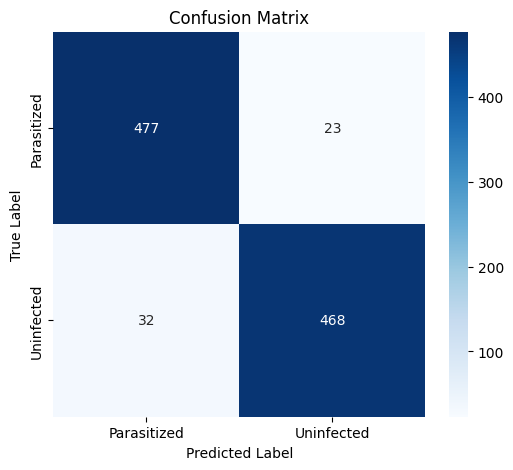

Classification Report:
               precision    recall  f1-score   support

 Parasitized       0.94      0.95      0.95       500
  Uninfected       0.95      0.94      0.94       500

    accuracy                           0.94      1000
   macro avg       0.95      0.95      0.94      1000
weighted avg       0.95      0.94      0.94      1000



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Prediksi pada test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
classes = train_dataset.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=classes))


## Uji Model dengan Random Sampling

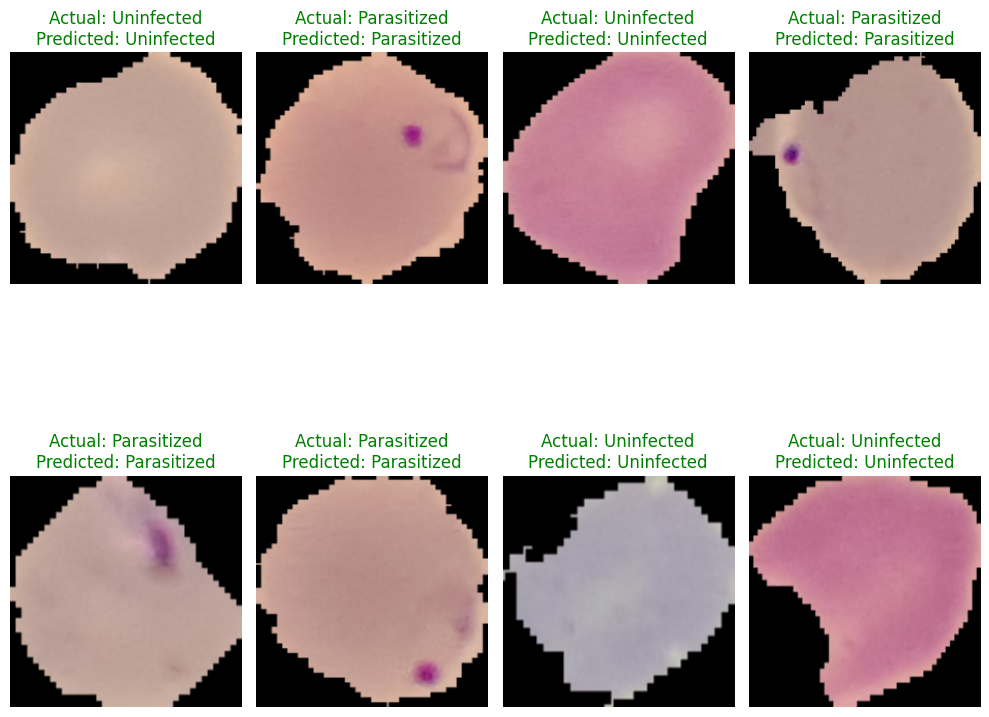

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import transforms

# Pastikan model dalam mode evaluasi
model.eval().to(device)

# Ambil sample random dari test set
num_samples = 8  # Jumlah gambar yang akan ditampilkan
indices = random.sample(range(len(test_dataset)), num_samples)  # Ambil index acak

# Load gambar dan label dari test dataset
images = torch.stack([test_dataset[i][0] for i in indices])  # Ambil gambar berdasarkan index acak
labels = torch.tensor([test_dataset[i][1] for i in indices])  # Ambil label asli
images, labels = images.to(device), labels.to(device)

# Prediksi model
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)  # Ambil kelas dengan skor tertinggi

# Mapping label ke nama kelas
class_names = train_dataset.classes  # Nama kelas dari dataset

# Tampilkan gambar beserta prediksi dan label aslinya
fig, axes = plt.subplots(2, 4, figsize=(10, 10))  # Grid 4x4
axes = axes.flatten()

for i in range(num_samples):
    img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert tensor ke NumPy dan ubah format
    img = img * 0.5 + 0.5  # Denormalisasi
    actual_label = class_names[labels[i].cpu().item()]
    predicted_label = class_names[preds[i].cpu().item()]

    # Tampilkan gambar
    axes[i].imshow(img)
    axes[i].axis("off")

    # Warna hijau jika prediksi benar, merah jika salah
    color = "green" if actual_label == predicted_label else "red"
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=color)

plt.tight_layout()
plt.show()